# Gym investment in L.A.

## Part 1:A description of the problem and a discussion of the background.

### Problem description: 
### **To invest new gym in L.A., how to decide the location which has enough customer and not competitive in the same area**

### Discussion:
### Background:
L.A. is the city which has multiple cultures, huge diversity and population composition. It’s the largest city in California, which has estimated 4 million people living in this area. The city of Los Angeles and its neighborhood are the home of eleven top level professional sports teams from different leagues like NBA, NHL, MLS and WNBA. Sport industry is popular in this area so it can be seen how competitive this industry is here.  Gym is the common place that everyone can use and can be found everywhere in cities. To invest new gym in a place, we should consider the location first. Good place decides the basis of cash flow or income of enterprise

### How to evaluate the neighborhood:
* find the most popular venue in every area and map into L.A. 
* set up the filerting criteria to select candidate


### Data Overview
* Geospatial data from the website: define the center location of postal code 

L.A.:http://boundaries.latimes.com/sets/  <br>
L.A. average population by neighborhood: https://maps.latimes.com/neighborhoods/population/density/neighborhood/list/ <br>
* Foursquare venue data: get a variety of venue in every area
https://foursquare.com/

In [1]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
from sklearn.cluster import KMeans
!pip install pyproj
import pyproj
import json # library to handle JSON files
import matplotlib.pyplot as plt
!conda install -c conda-forge geopy --yes 
# uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

#!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Solving environment: ...working... done

## Package Plan ##

  environment location: C:\ProgramData\Anaconda3

  added / updated specs:
    - geopy


The following packages will be UPDATED:

  ca-certificates                     2020.4.5.1-hecc5488_0 --> 2020.4.5.2-hecda079_0


Preparing transaction: ...working... done
Verifying transaction: ...working... failed



EnvironmentNotWritableError: The current user does not have write permissions to the target environment.
  environment location: C:\ProgramData\Anaconda3




Libraries imported.


In [2]:
with open('la-county-neighborhoods-current.geojson') as json_data:
    la_data = json.load(json_data)
A_data = la_data['features']

In [3]:
# define the dataframe columns
column_names = [ 'Neighborhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
la_neighborhood = pd.DataFrame(columns=column_names)


In [4]:
# the L.A. data doesn't provide the center location of neighborhoods
# it needs to calculate teh center point.
for data in A_data:
    #borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates'][0][0]
    tmp_lat = [];tmp_lon = []
    for j in range(len(neighborhood_latlon)):
        tmp_lat.append(neighborhood_latlon[j][1])
        tmp_lon.append(neighborhood_latlon[j][0])
        
    neighborhood_lat = np.mean(tmp_lat)
    neighborhood_lon = np.mean(tmp_lon)
    
    la_neighborhood = la_neighborhood.append({'Neighborhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [5]:
la_neighborhood.head(10) # directly use neighborhood instead of adding borough in L.A.

,Neighborhood,Latitude,Longitude
0,Acton,34.495476,-118.172093
1,Adams-Normandie,34.032255,-118.302251
2,Agoura Hills,34.140124,-118.743514
3,Agua Dulce,34.493945,-118.309488
4,Alhambra,34.083083,-118.136335
5,Alondra Park,33.895180,-118.333434
6,Altadena,34.189694,-118.138497
7,Angeles Crest,34.327908,-117.985401
8,Arcadia,34.123730,-118.029431
9,Arleta,34.240187,-118.431711


In [6]:
address = 'Los angeles City, LA'

geolocator = Nominatim(user_agent="la_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude

# create map using latitude and longitude values
map_la = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, neighborhood in zip(la_neighborhood['Latitude'], la_neighborhood['Longitude'], la_neighborhood['Neighborhood']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_la)  
    
map_la

In [7]:
def getNearbyVenues(names, latitudes, longitudes, radius=500,LIMIT=100):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

### To reduce the time of retreiving data, I have saved the data I'll use.

In [8]:
 
# Assign the ID/Secret and some parameters of API

#VERSION = '20200508' # Foursquare API version
#LIMIT = 200 # limit of number of venues returned by Foursquare API
#radius = 500 # define radius
#print('Your credentails:')
#print('CLIENT_ID: ' + CLIENT_ID)
#print('CLIENT_SECRET:' + CLIENT_SECRET)
#LA_venues = getNearbyVenues(names=la_neighborhood['Neighborhood'],
#                                   latitudes=la_neighborhood['Latitude'],
#                                   longitudes=la_neighborhood['Longitude']
 #                                 )


In [9]:
#LA_venues.to_csv('LA_venue.csv')
LA_venues = pd.read_csv('LA_venue.csv')
LA_venues.head()

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,0,Acton,34.495476,-118.172093,Alma Gardening Co.,34.494762,-118.172550,Construction & Landscaping
1,1,Adams-Normandie,34.032255,-118.302251,Orange Door Sushi,34.032485,-118.299368,Sushi Restaurant
2,2,Adams-Normandie,34.032255,-118.302251,Shell,34.033095,-118.300025,Gas Station
3,3,Adams-Normandie,34.032255,-118.302251,Loren Miller Recreational Park,34.031335,-118.303717,Playground
4,4,Adams-Normandie,34.032255,-118.302251,Tacos La Estrella,34.032230,-118.300757,Taco Place


In [10]:
# import requests
# url = 'https://maps.latimes.com/neighborhoods/population/density/neighborhood/list/'
# r = requests.get(url)
# pp = pd.read_html(r.text)
# pop_data = pp[1]
# pop_data.head()
# pop_data.to_csv('Population_data.csv')

In [11]:
pop_data = pd.read_csv('Population_data.csv')
pop_data.shape

(265, 4)

Text(0, 0.5, 'Population per square miles')

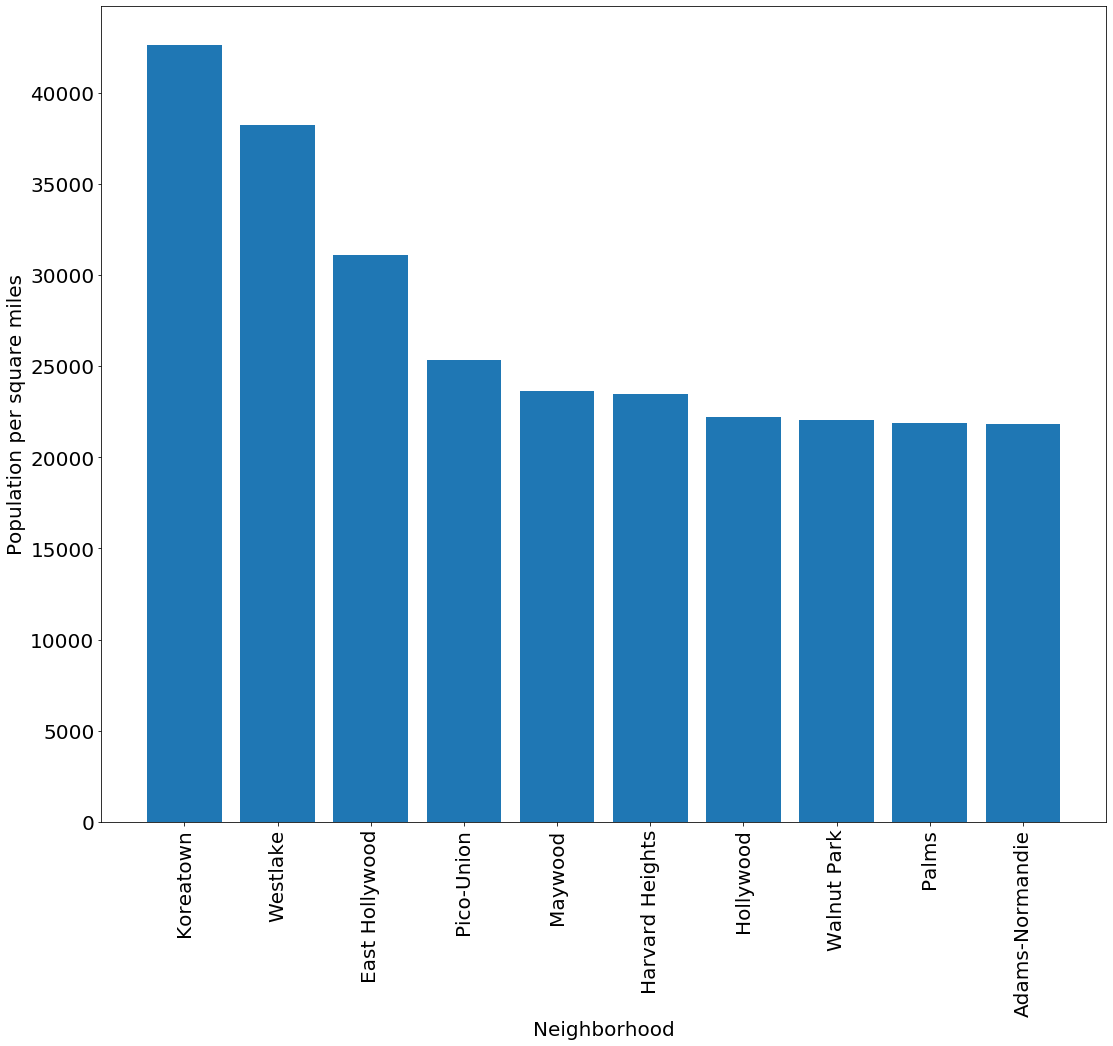

In [12]:
plt.figure(figsize=(18,15))
plt.bar(pop_data['Neighborhood'][0:10],pop_data['Population per Sqmi'][0:10])
plt.xticks(rotation='vertical',fontsize =20)
plt.yticks(fontsize = 20)
plt.xlabel('Neighborhood',size = 20)
plt.ylabel('Population per square miles',size = 20)

In [13]:
A = np.unique(LA_venues['Venue Category'])
gym_cat = [s for s in A if "Gym" in s] 
res_cat = [s for s in A if "Restaurant" in s] 


In [14]:
LA_venues.groupby('Neighborhood').count()
LA_onehot = pd.get_dummies(LA_venues[['Venue Category']], prefix="", prefix_sep="")
LA_onehot['Neighborhood'] = LA_venues['Neighborhood'] 

# move neighborhood column to the first column, need to check the index of Neighborhood
fixed_columns = [LA_onehot.columns[(LA_onehot.columns=='Neighborhood').argmax()]] + list(LA_onehot.columns[LA_onehot.columns!='Neighborhood'])
LA_onehot = LA_onehot[fixed_columns]

LA_onehot.head(10)

,Neighborhood,ATM,Accessories Store,Airport Lounge,American Restaurant,Amphitheater,Animal Shelter,Antique Shop,Arcade,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Australian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Court,Beach,Beer Garden,Big Box Store,Bike Shop,Bike Trail,Bistro,Board Shop,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Camera Store,Campground,Candy Store,Cantonese Restaurant,Car Wash,Caribbean Restaurant,Carpet Store,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Circus School,Clothing Store,Cocktail Bar,Coffee Shop,College Academic Building,College Baseball Diamond,College Cafeteria,College Residence Hall,College Theater,Comedy Club,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Disc Golf,Discount Store,Distillery,Dive Bar,Dive Spot,Doctor's Office,Dog Run,Donburi Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Event Space,Falafel Restaurant,Farmers Market,Fast Food Restaurant,Filipino Restaurant,Financial or Legal Service,Fish & Chips Shop,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Truck,Football Stadium,Fountain,Fraternity House,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Garden,Garden Center,Gas Station,Gastropub,General College & University,General Entertainment,German Restaurant,Gift Shop,Golf Course,Golf Driving Range,Gourmet Shop,Government Building,Greek Restaurant,Grocery Store,Gun Shop,Gym,Gym / Fitness Center,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Insurance Office,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Karaoke Bar,Kids Store,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Laundry Service,Lawyer,Light Rail Station,Lighthouse,Lighting Store,Lingerie Store,Liquor Store,Locksmith,Lounge,Marijuana Dispensary,Market,Martial Arts Dojo,Massage Studio,Medical Center,Mediterranean Restaurant,Men's Store,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Monument / Landmark,Motel,Mountain,Movie Theater,Moving Target,Museum,Music Store,Music Venue,New American Restaurant,Nightclub,Nightlife Spot,Noodle House,Office,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Other Repair Shop,Outdoor Sculpture,Outdoors & Recreation,Paper / Office Supplies Store,Park,Pastry Shop,Pedestrian Plaza,Performing Arts Venue,Persian Restaurant,Peruvian Restaurant,Pet Store,Pharmacy,Pie Shop,Pier,Pilates Studio,Pizza Place,Playground,Plaza,Poke Place,Pool,Pool Hall,Pop-Up Shop,Print Shop,Pub,Racetrack,Ramen Restaurant,Record Shop,Recreation Center,Rental Car Location,Rental Service,Reservoir,Residential Building (Apartment / Condo),Rest Area,Restaurant,River,Road,Rock Climbing Spot,Rock Club,Sake Bar,Salad Place,Salon / Barbershop,Salvadoran Restaurant,Sandwich Place,Satay Restaurant,Scenic Lookout,Science Museum,Sculpture Garden,Seafood Restaurant,Shabu-Shabu Restaurant,Shipping Store,Shoe Repair,Shoe Store,Shop & Service,Shopping Mall,Shopping Pl

In [15]:
LA_grouped = LA_onehot.groupby('Neighborhood').mean().reset_index()
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = LA_grouped['Neighborhood']

for ind in np.arange(LA_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(LA_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head()

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Acton,Construction & Landscaping,Yoga Studio,Fast Food Restaurant,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Event Space,Falafel Restaurant
1,Adams-Normandie,Sushi Restaurant,Gas Station,Market,Taco Place,Playground,Yoga Studio,Falafel Restaurant,Electronics Store,Empanada Restaurant,English Restaurant
2,Agoura Hills,Furniture / Home Store,Optical Shop,Rental Car Location,BBQ Joint,Miscellaneous Shop,Financial or Legal Service,Gas Station,Discount Store,Empanada Restaurant,English Restaurant
3,Alhambra,Convenience Store,Video Store,Pizza Place,Pet Store,Breakfast Spot,Mexican Restaurant,Bagel Shop,Sporting Goods Shop,Health Food Store,Falafel Restaurant
4,Alondra Park,Park,Dive Bar,Yoga Studio,Farmers Market,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Event Space,Falafel Restaurant


In [16]:
ix = LA_grouped[np.array(gym_cat)]!=0
sel_ix = ix.any(axis='columns')

selected_area=neighborhoods_venues_sorted.iloc[np.where(sel_ix==True)]
selected_area

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
6,Arcadia,Gym,Child Care Service,Basketball Court,Yoga Studio,Dry Cleaner,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Event Space
22,Beverly Grove,Gym,Japanese Restaurant,Juice Bar,Mediterranean Restaurant,Boutique,Cosmetics Shop,Spa,Sushi Restaurant,Cocktail Bar,Coffee Shop
25,Boyle Heights,Mexican Restaurant,Seafood Restaurant,Mobile Phone Shop,Juice Bar,Bar,Theater,Grocery Store,Gym,Bakery,Burger Joint
28,Broadway-Manchester,Food,Gym,Mobile Phone Shop,Yoga Studio,Farmers Market,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Event Space
34,Century City,Coffee Shop,Mexican Restaurant,Clothing Store,Pizza Place,Cosmetics Shop,Department Store,Salad Place,Food Truck,Italian Restaurant,Shoe Store
39,Cheviot Hills,Tennis Court,Gym,Gym / Fitness Center,Business Service,Yoga Studio,Falafel Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant
43,Commerce,Convenience Store,Gym,Mexican Restaurant,Bank,Coffee Shop,Yoga Studio,Farmers Market,Eastern European Restaurant,Electronics Store,Empanada Restaurant
49,Del Aire,Optical Shop,Fast Food Restaurant,Gym,Mexican Restaurant,Eastern European Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Event Space,Falafel Restaurant
50,Del Rey,Martial Arts Dojo,Sushi Restaurant,Thai Restaurant,Park,Gym / Fitness Center,Donut Shop,Doctor's Office,Bakery,Breakfast Spot,Grocery Store
54,Duarte,Mediterranean Restaurant,Donut Shop,Gun Shop,Sandwich Place,Mexican Restaurant,Restaurant,Pizza Place,Auto Garage,Gym / Fitness Center,Pharmacy


In [17]:
sort_pop = pop_data.sort_values(by=['Neighborhood'])
selected_pop = sort_pop.loc[sort_pop['Neighborhood'].isin(selected_area['Neighborhood'])]
selected_grouped = LA_grouped.loc[LA_grouped['Neighborhood'].isin(selected_area['Neighborhood'])]
selected_grouped = selected_grouped[np.intersect1d(selected_grouped.columns, selected_area.columns)]
Data = pd.merge(selected_area,selected_pop[['Neighborhood','Population per Sqmi']])
Data.head()
Data.shape

(36, 12)

In [18]:
Data = Data.sort_values(by='Population per Sqmi',ascending=False).reset_index(drop=True)

In [19]:
# select 15000 per square mile, and there's no gym in top 10 venues
for i in range(10):
    if i ==0:
        a = Data[Data.columns[i+1]].str.contains('Gym')
        c = a
    else:
        a = Data[Data.columns[i+1]].str.contains('Gym')
        c = np.logical_or(a,c)


In [20]:
final_ix = np.logical_and((Data['Population per Sqmi']>=15000),  ~(c))
final_ix.head()

0    False
1     True
2    False
3    False
4    False
dtype: bool

In [21]:
final_selection = Data.loc[final_ix,:]
final_selection.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,Population per Sqmi
1,Hollywood,Coffee Shop,Museum,Thai Restaurant,Hotel,American Restaurant,Movie Theater,Juice Bar,Fast Food Restaurant,Cosmetics Shop,Chocolate Shop,22193


### Analysis

In [22]:
sel_calidate = la_neighborhood.loc[la_neighborhood['Neighborhood'].isin(final_selection['Neighborhood']),:]
sel_calidate 

,Neighborhood,Latitude,Longitude
106,Hollywood,34.098904,-118.339189


In [23]:
Holly =LA_venues.loc[LA_venues['Neighborhood'].isin(sel_calidate['Neighborhood']),:]
Holly.head(20)

,Unnamed: 0,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
1110,1110,Hollywood,34.098904,-118.339189,L’Antica Pizzeria da Michele,34.099063,-118.337444,Italian Restaurant
1111,1111,Hollywood,34.098904,-118.339189,Qwench Juice Bar,34.097824,-118.340460,Juice Bar
1112,1112,Hollywood,34.098904,-118.339189,In-N-Out Burger,34.098273,-118.341667,Fast Food Restaurant
1113,1113,Hollywood,34.098904,-118.339189,El Capitan Theatre,34.101102,-118.339794,Movie Theater
1114,1114,Hollywood,34.098904,-118.339189,Drnk Coffee & Tea,34.097859,-118.340388,Coffee Shop
1115,1115,Hollywood,34.098904,-118.339189,vegan house thai bistro,34.097178,-118.338794,Thai Restaurant
1116,1116,Hollywood,34.098904,-118.339189,Chick-fil-A,34.097757,-118.338254,Fast Food Restaurant
1117,1117,Hollywood,34.098904,-118.339189,Catalina Bar and Grill,34.098222,-118.337471,Jazz Club
1118,1118,Hollywood,34.098904,-118.339189,Javista Organic Coffee Bar,34.098218,-118.336544,Coffee Shop
1119,1119,Hollywood,34.098904,-118.339189,The Hollywood Museum,34.101087,-118.338613,Museum


In [24]:
# create map using latitude and longitude values
map_holly = folium.Map(location=[Holly.iloc[1,2], Holly.iloc[1,3]], zoom_start=15)

# add markers to map
for lat, lng, neighborhood in zip(Holly['Venue Latitude'], Holly['Venue Longitude'], Holly['Venue']):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_holly)  
map_holly



In [25]:
Cent=Holly.loc[[1150,1121],['Venue Latitude','Venue Longitude','Venue']].values
for lat, lng, neighborhood in zip(Cent[:,0], Cent[:,1], Cent[:,2]):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='red',
        fill=True,
        fill_color='#FF0000',
        fill_opacity=0.7,
        parse_html=False).add_to(map_holly)  
map_holly


In [26]:
number_of_clusters = 3
good_latitudes = Cent[:,0]
good_longitudes = Cent[:,1]

good_locations = [[lat, lon] for lat, lon in zip(good_latitudes, good_longitudes)]
good_xys = good_locations
kmeans = KMeans(n_clusters=number_of_clusters, random_state=0).fit(Holly.loc[:,['Venue Latitude','Venue Longitude']].values)

cluster_centers = [cc for cc in kmeans.cluster_centers_]
cluster_centers = np.concatenate(cluster_centers,axis=0 )


In [29]:
for lat, lng,neighborhood in zip(cluster_centers[0::2], cluster_centers[1::2],range(number_of_clusters)):
    label = '{}'.format(neighborhood)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=60,
        popup=label,
        color='Green',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0,
        parse_html=False).add_to(map_holly)  
map_holly

In [28]:
cluster_centers[0::2], cluster_centers[1::2]

(array([34.09650119, 34.10195824, 34.09971867]),
 array([-118.33978603, -118.34034062, -118.33615019]))